In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
def Dispersion(data):
  mean = data.mean()
  D = 0
  for i in data:
    D += (i - mean)**2
  D = D/(len(data)-1)
  return D
def standartdeviation(data):
  return sqrt(Dispersion(data))
def range1(data):
  return data.max() - data.min()
def cv(data):
  return standartdeviation(data)/data.mean()
def standarterror(data):
  return standartdeviation(data)/data.shape[0]
def countall(data):
  di = {'data': [Dispersion(data), standartdeviation(data), data.mean(), data.median(), cv(data), range1(data)],
        'name': ['dispersion', 'standart deviation', 'mean', 'median', 'cv', 'range']}
  df = pd.DataFrame(di)
  return df
def countall_dict(data):
  di = {'dispersion': Dispersion(data),
        'standart deviation': standartdeviation(data),
        'mean': data.mean(),
        'median': data.median(),
        'STD(cv)': cv(data),
        'range': range1(data),
        'sum': data.sum(),
        'max': data.max(),
        'min': data.min()}
  return di
def quantile(data):
  q1 = np.quantile(data, 0.25)
  q3 = np.quantile(data, 0.75)
  IQR = q3 - q1
  return IQR

In [3]:
df_train_X = pd.read_csv('PlaneChalData/train_X.csv')
df_train_y = pd.read_csv('PlaneChalData/train_y.csv')
df_test_X = pd.read_csv('PlaneChalData/test1_X.csv')

# Preprocess data


In [4]:
df_train_X['Income_minus_all'] = df_train_X['agg_FinanceAndTaxesFTS__g_contractor__Income__last__ALL_TIME'] - (df_train_X['agg_FinanceAndTaxesFTS__g_contractor__Expenses__last__ALL_TIME'] + df_train_X['agg_FinanceAndTaxesFTS__g_contractor__TaxArrearsSum__last__ALL_TIME'] + df_train_X['agg_FinanceAndTaxesFTS__g_contractor__TaxPenaltiesSum__last__ALL_TIME'] + df_train_X['agg_FinanceAndTaxesFTS__g_contractor__TaxesSum__last__ALL_TIME'])
df_test_X['Income_minus_all'] = df_test_X['agg_FinanceAndTaxesFTS__g_contractor__Income__last__ALL_TIME'] - (df_test_X['agg_FinanceAndTaxesFTS__g_contractor__Expenses__last__ALL_TIME'] + df_test_X['agg_FinanceAndTaxesFTS__g_contractor__TaxArrearsSum__last__ALL_TIME'] + df_test_X['agg_FinanceAndTaxesFTS__g_contractor__TaxPenaltiesSum__last__ALL_TIME'] + df_test_X['agg_FinanceAndTaxesFTS__g_contractor__TaxesSum__last__ALL_TIME'])

df_train_X['subms_count_prod_contract_curr_sum'] = df_train_X.agg_cec_requests__g_contract__request_id__all__count__ALL_TIME * df_train_X.contract_current_sum
df_test_X['subms_count_prod_contract_curr_sum'] = df_test_X.agg_cec_requests__g_contract__request_id__all__count__ALL_TIME * df_test_X.contract_current_sum

df_train_X['defects_with_materials'] = df_train_X['agg_materials__g_contract__material_type_id__countDistinct__ALL_TIME'] * df_train_X['agg_sroomer__g_contractor__sroomer_id__count__ALL_TIME']
df_test_X['defects_with_materials'] = df_test_X['agg_materials__g_contract__material_type_id__countDistinct__ALL_TIME'] * df_test_X['agg_sroomer__g_contractor__sroomer_id__count__ALL_TIME']

df_train_X['IndexOfDueDiligence_prod_CreditLimitSum'] = df_train_X.agg_ConsolidatedIndicator__g_contractor__Index__IndexOfDueDiligence__mean__ALL_TIME * df_train_X.agg_spark_extended_report__g_contractor__CreditLimitSum__last__ALL_TIME
df_test_X['IndexOfDueDiligence_prod_CreditLimitSum'] = df_test_X.agg_ConsolidatedIndicator__g_contractor__Index__IndexOfDueDiligence__mean__ALL_TIME * df_test_X.agg_spark_extended_report__g_contractor__CreditLimitSum__last__ALL_TIME

df_train_X['agg_cec_requests__g_contract__total_sum_rejected__all__sum__ALL_TIME'] = df_train_X['agg_cec_requests__g_contract__request_id__all__count__ALL_TIME'] - df_train_X['agg_cec_requests__g_contract__total_sum_accepted__all__sum__ALL_TIME']
df_test_X['agg_cec_requests__g_contract__total_sum_rejected__all__sum__ALL_TIME'] = df_test_X['agg_cec_requests__g_contract__request_id__all__count__ALL_TIME'] - df_test_X['agg_cec_requests__g_contract__total_sum_accepted__all__sum__ALL_TIME']

In [5]:
# columns_test = df_test_X.dropna(axis=1).columns
# columns_train = df_train_X.dropna(axis=1).columns
columns_test = df_test_X.fillna(0).columns
columns_train = df_train_X.fillna(0).columns
df_test_X = df_test_X.fillna(0)
df_train_X = df_train_X.fillna(0)

In [6]:
columns = columns_test
df_test_X = df_test_X[columns]
df_train_X = df_train_X[columns]

In [7]:
def preprocess_datetime(df):
    # Ensure columns are in datetime format
    df['report_date'] = pd.to_datetime(df['report_date'])
    df['contract_date'] = pd.to_datetime(df['contract_date'])

    # Extract year, month, day, weekday, etc.
    df['report_year'] = df['report_date'].dt.year
    df['report_month'] = df['report_date'].dt.month
    df['report_day'] = df['report_date'].dt.day
    df['report_weekday'] = df['report_date'].dt.weekday

    df['contract_year'] = df['contract_date'].dt.year
    df['contract_month'] = df['contract_date'].dt.month
    df['contract_day'] = df['contract_date'].dt.day
    df['contract_weekday'] = df['contract_date'].dt.weekday

    # Drop original datetime columns if no longer needed
    df = df.drop(columns=['report_date', 'contract_date'])
    
    # print([i for i in df.columns if 'date' in i])
    return df

In [8]:
X_train = preprocess_datetime(df_train_X)
X_test = preprocess_datetime(df_test_X)

In [9]:
# Первая итерация
X_train = X_train.drop(columns=['agg_ks2__g_contract__id__all__count__1W', 'agg_spark_extended_report__g_contractor__PledgeeCeasedCount__last__ALL_TIME', 'report_year', 'report_day', 'report_weekday'])
X_test = X_test.drop(columns=['agg_ks2__g_contract__id__all__count__1W', 'agg_spark_extended_report__g_contractor__PledgeeCeasedCount__last__ALL_TIME', 'report_year', 'report_day', 'report_weekday'])
# Вторая итерация
X_train = X_train.drop(columns = ['agg_cec_requests__g_contract__request_id__all__count__1W', 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__1W', 'agg_payments__g_contract__sum__all__countDistinct__1W', 'agg_BoardOfDirectors__g_contractor__Name__count__ALL_TIME'])
X_test = X_test.drop(columns = ['agg_cec_requests__g_contract__request_id__all__count__1W', 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__1W', 'agg_payments__g_contract__sum__all__countDistinct__1W', 'agg_BoardOfDirectors__g_contractor__Name__count__ALL_TIME'])
# После второй итерации не осталось таких столбцов
X_train.head()

,contract_id,specialization_id,contract_init_sum,project_id,building_id,contractor_id,contract_current_sum,agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME,agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__last__ALL_TIME,agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__mean__ALL_TIME,...,Income_minus_all,subms_count_prod_contract_curr_sum,defects_with_materials,IndexOfDueDiligence_prod_CreditLimitSum,agg_cec_requests__g_contract__total_sum_rejected__all__sum__ALL_TIME,report_month,contract_year,contract_month,contract_day,contract_weekday
0,5433,18,1.115267,43,701,438,0.793952,-0.539030,0.00000,0.000000,...,0.0,0.115448,-2.979261,-0.031876,-0.932917,1,2022,5,10,1
1,6875,18,1.608002,31,268,438,2.681675,0.743673,1.67389,1.731805,...,0.0,1.307624,-1.932617,-0.031876,-1.042694,1,2022,8,21,6
2,1476,18,-0.360764,31,268,438,-0.416432,-0.539030,0.00000,0.000000,...,0.0,0.138954,0.160671,-0.031876,0.019010,1,2022,10,17,0
3,4469,12,-0.089303,43,697,484,-0.193827,-0.539030,0.00000,0.000000,...,0.0,0.004980,0.087678,-0.041857,-0.258230,1,2022,4,20,2
4,1330,12,-0.515778,49,224,484,0.133446,0.743673,0.54505,0.550885,...,0.0,-0.021695,0.087678,-0.041857,-0.873302,1,2022,3,2,2


In [10]:
# Удаляем те столбцы, влияние которых ниже порога 0.3
X_train = X_train.drop(columns=['agg_cec_requests__g_contract__request_id__all__count__2W',
 'agg_cec_requests__g_contract__request_id__all__count__3W',
 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__2W',
 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__3W',
 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__6W',
 'agg_cec_requests__g_contract__time_btw_requests__all__mean__1M',
 'agg_payments__g_contract__sum__all__countDistinct__2W',
 'agg_payments__g_contract__sum__all__countDistinct__4W',
 'agg_payments__g_contract__sum__all__countDistinct__8W',
 'agg_payments__g_contract__sum__all__sum__1W',
 'agg_payments__g_contract__sum__all__sum__2W',
 'agg_payments__g_contract__sum__all__sum__4W',
 'agg_ks2__g_contract__id__all__count__2W',
 'agg_ks2__g_contract__id__all__count__4W',
 'agg_ks2__g_contract__id__all__count__12W',
 'agg_ks2__g_contract__total_sum__all__sum__1W',
 'agg_ks2__g_contract__total_sum__all__sum__2W',
 'agg_ks2__g_contract__total_sum__all__sum__4W',
 'agg_spass_applications__g_contract__appl_count_week__mean__1W',
 'agg_spass_applications__g_contract__appl_count_week__mean__2W',
 'agg_spass_applications__g_contract__appl_count_week__mean__3W',
 'agg_spass_applications__g_contract__appl_count_week__mean__5W',
 'agg_workers__g_contract__fact_workers__all__mean__5W',
 'agg_materials__g_contract__order_id__countDistinct__1W'])
X_test = X_test.drop(columns=['agg_cec_requests__g_contract__request_id__all__count__2W',
 'agg_cec_requests__g_contract__request_id__all__count__3W',
 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__2W',
 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__3W',
 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__6W',
 'agg_cec_requests__g_contract__time_btw_requests__all__mean__1M',
 'agg_payments__g_contract__sum__all__countDistinct__2W',
 'agg_payments__g_contract__sum__all__countDistinct__4W',
 'agg_payments__g_contract__sum__all__countDistinct__8W',
 'agg_payments__g_contract__sum__all__sum__1W',
 'agg_payments__g_contract__sum__all__sum__2W',
 'agg_payments__g_contract__sum__all__sum__4W',
 'agg_ks2__g_contract__id__all__count__2W',
 'agg_ks2__g_contract__id__all__count__4W',
 'agg_ks2__g_contract__id__all__count__12W',
 'agg_ks2__g_contract__total_sum__all__sum__1W',
 'agg_ks2__g_contract__total_sum__all__sum__2W',
 'agg_ks2__g_contract__total_sum__all__sum__4W',
 'agg_spass_applications__g_contract__appl_count_week__mean__1W',
 'agg_spass_applications__g_contract__appl_count_week__mean__2W',
 'agg_spass_applications__g_contract__appl_count_week__mean__3W',
 'agg_spass_applications__g_contract__appl_count_week__mean__5W',
 'agg_workers__g_contract__fact_workers__all__mean__5W',
 'agg_materials__g_contract__order_id__countDistinct__1W'])

X_train = X_train.drop(columns=['agg_cec_requests__g_contract__total_sum_accepted__all__sum__5W',
 'agg_cec_requests__g_contract__time_btw_requests__all__mean__3M',
 'agg_spass_applications__g_contract__appl_count_week__mean__4W',
 'agg_materials__g_contract__order_id__countDistinct__2W',
 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__1W'])

X_test = X_test.drop(columns=['agg_cec_requests__g_contract__total_sum_accepted__all__sum__5W',
 'agg_cec_requests__g_contract__time_btw_requests__all__mean__3M',
 'agg_spass_applications__g_contract__appl_count_week__mean__4W',
 'agg_materials__g_contract__order_id__countDistinct__2W',
 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__1W'])


# Distortion


/tmp/ipykernel_23895/1813159799.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


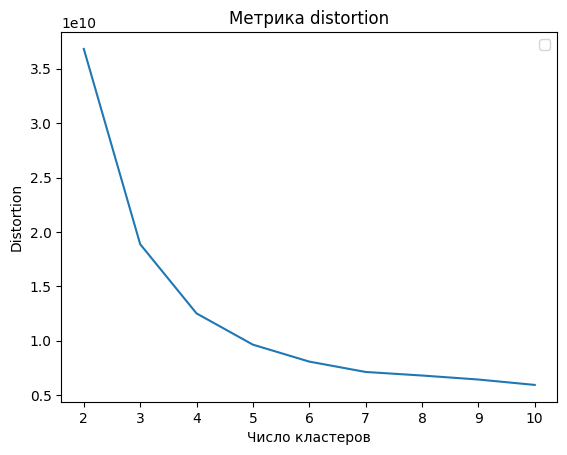

In [11]:
clusters = range(2, 11)
distortions = []

for cluster in clusters:
    km = KMeans(n_clusters=cluster, random_state=42)
    km.fit(X_train)
    distortions.append(km.inertia_)

plt.plot(clusters, distortions)
plt.title('Метрика distortion')
plt.xlabel('Число кластеров')
plt.ylabel('Distortion')
plt.legend()
plt.show()

In [12]:
km = KMeans(n_clusters=5, random_state = 42).fit(X_train)


In [13]:
clusters = km.labels_
cluster_df = pd.DataFrame({"Segment_____my_claster": clusters})
cluster_df.to_csv("DataProcess/Clusterization.csv", index=False)

In [16]:
clusters_test = km.predict(X_test)
clusters_test_df = pd.DataFrame({"Segment_____my_claster": clusters_test})
clusters_test_df.to_csv("DataProcess/Clusterization_test.csv", index=False)